In [1]:
# 3. Load a specific range of slices with a step
# 4. Display a sample of the loaded images
# 5. Load specific slices for training (8 slices distributed throughout the volume)
# Display the training images
# 6. Train on multiple slices
# 7. Denoise and compare the sample images
# 8. Display detailed results
# 9. Show detailed crop comparisons
# 10. Process and denoise all slices (optional)

In [2]:
# 1. Install required packages
!pip install -q n2v tensorflow==2.13.0 csbdeep pillow tqdm

# 1. Import dependencies
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from n2v.models import N2VConfig, N2V
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from csbdeep.utils import plot_history

# 2. Set up paths and parameters
TOMO_PATH = '/kaggle/input/byu-locating-bacterial-flagellar-motors-2025/train/tomo_00e047'
OUTPUT_PATH = '/kaggle/working'
MODEL_PATH = '/kaggle/working/models'

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_PATH, exist_ok=True)
os.makedirs(MODEL_PATH, exist_ok=True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.0/147.0 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.9/146.9 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.5/124.5 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.4/109.4 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.3/107.3 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.4/103.4 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [3]:
def load_slices(path, start_idx=0, end_idx=300, step=20):
    """Load a range of JPEG images from the path with specified indices and step"""
    all_files = sorted(glob.glob(os.path.join(path, '*.jpg')))
    
    if len(all_files) == 0:
        raise ValueError(f"No JPEG files found in {path}")
    
    print(f"Found {len(all_files)} JPEG files in the directory")
    
    # Make sure our range is valid
    start_idx = max(0, min(start_idx, len(all_files) - 1))
    end_idx = max(start_idx + 1, min(end_idx, len(all_files)))
    
    # Select files with the specified step
    selected_indices = list(range(start_idx, end_idx, step))
    selected_files = [all_files[i] for i in selected_indices]
    
    print(f"Selected {len(selected_files)} slices from index {start_idx} to {end_idx-1} with step {step}")
    print(f"Selected indices: {selected_indices}")
    
    # Load the images into a list
    images = []
    filenames = []
    
    for file in tqdm(selected_files, desc="Loading slices"):
        # Load and convert to grayscale
        img = np.array(Image.open(file).convert('L'))
        images.append(img)
        filenames.append(os.path.basename(file))
    
    return images, filenames, selected_files, all_files

images, filenames, image_files, all_files = load_slices(TOMO_PATH, start_idx=0, end_idx=300, step=20)

Found 300 JPEG files in the directory
Selected 15 slices from index 0 to 299 with step 20
Selected indices: [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280]


Loading slices: 100%|██████████| 15/15 [00:00<00:00, 59.29it/s]


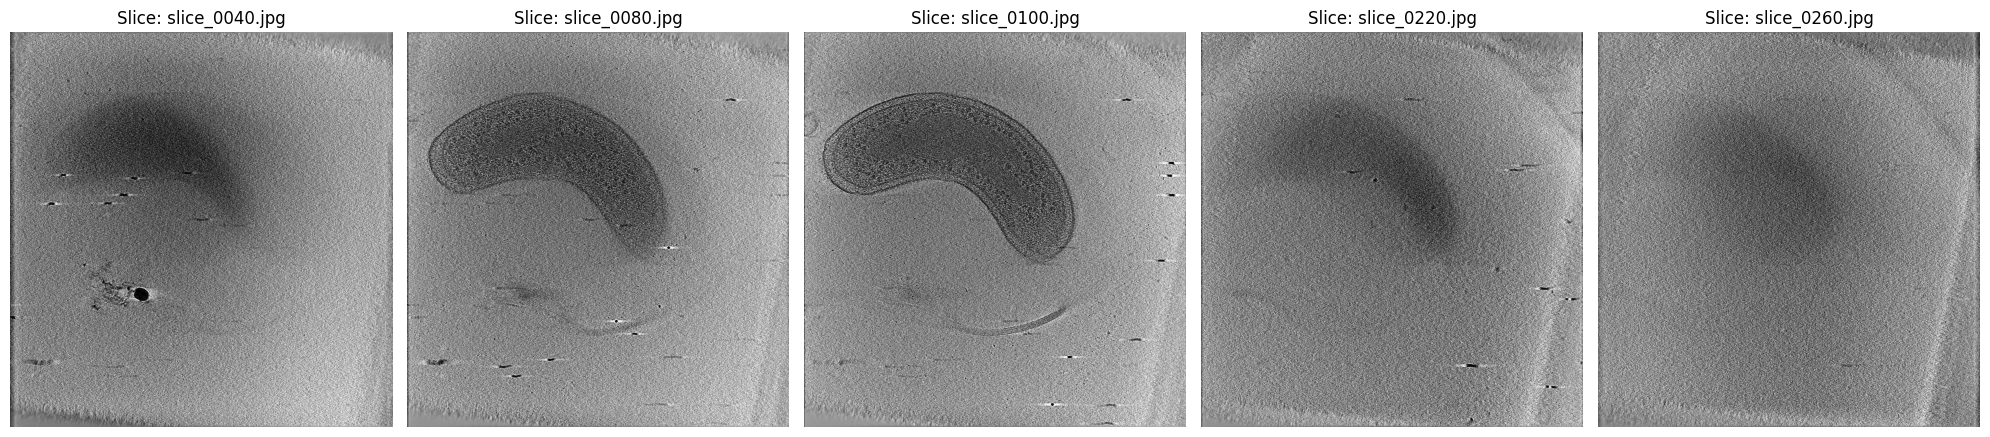

In [4]:
def display_sample_slices(images, filenames, num_samples=5):
    # Select random samples if we have more than requested
    if len(images) > num_samples:
        indices = sorted(random.sample(range(len(images)), num_samples))
    else:
        indices = range(len(images))
    
    fig, axes = plt.subplots(1, len(indices), figsize=(20, 5))
    if len(indices) == 1:
        axes = [axes]  # Handle the case of a single image
    
    for i, idx in enumerate(indices):
        axes[i].imshow(images[idx], cmap='gray')
        axes[i].set_title(f'Slice: {filenames[idx]}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_PATH, 'sample_slices.png'))
    plt.show()
    
    return indices  # Return the indices for later use

sample_indices = display_sample_slices(images, filenames)

In [9]:
def load_specific_slices(file_list, num_slices=100):
    """Load specific slices from the file list, evenly distributed through the volume"""
    total_files = len(file_list)
    
    if total_files < num_slices:
        print(f"Warning: Requested {num_slices} slices but only {total_files} available")
        indices = list(range(total_files))
    else:
        # Calculate evenly spaced indices
        step = total_files // num_slices
        indices = [i * step for i in range(num_slices)]
        # Make sure we don't exceed the list bounds
        indices = [min(i, total_files - 1) for i in indices]
    
    training_images = []
    training_filenames = []
    
    for idx in indices:
        file = file_list[idx]
        img = np.array(Image.open(file).convert('L'))
        training_images.append(img)
        training_filenames.append(os.path.basename(file))
    
    print(f"Loaded {len(training_images)} slices for training")
    print(f"Training on slices at indices: {indices}")
    print(f"Training on: {training_filenames}")
    
    return training_images, training_filenames, indices

# Load 8 evenly distributed slices for training
training_images, training_filenames, training_indices = load_specific_slices(all_files, num_slices=10)

Loaded 10 slices for training
Training on slices at indices: [0, 30, 60, 90, 120, 150, 180, 210, 240, 270]
Training on: ['slice_0000.jpg', 'slice_0030.jpg', 'slice_0060.jpg', 'slice_0090.jpg', 'slice_0120.jpg', 'slice_0150.jpg', 'slice_0180.jpg', 'slice_0210.jpg', 'slice_0240.jpg', 'slice_0270.jpg']


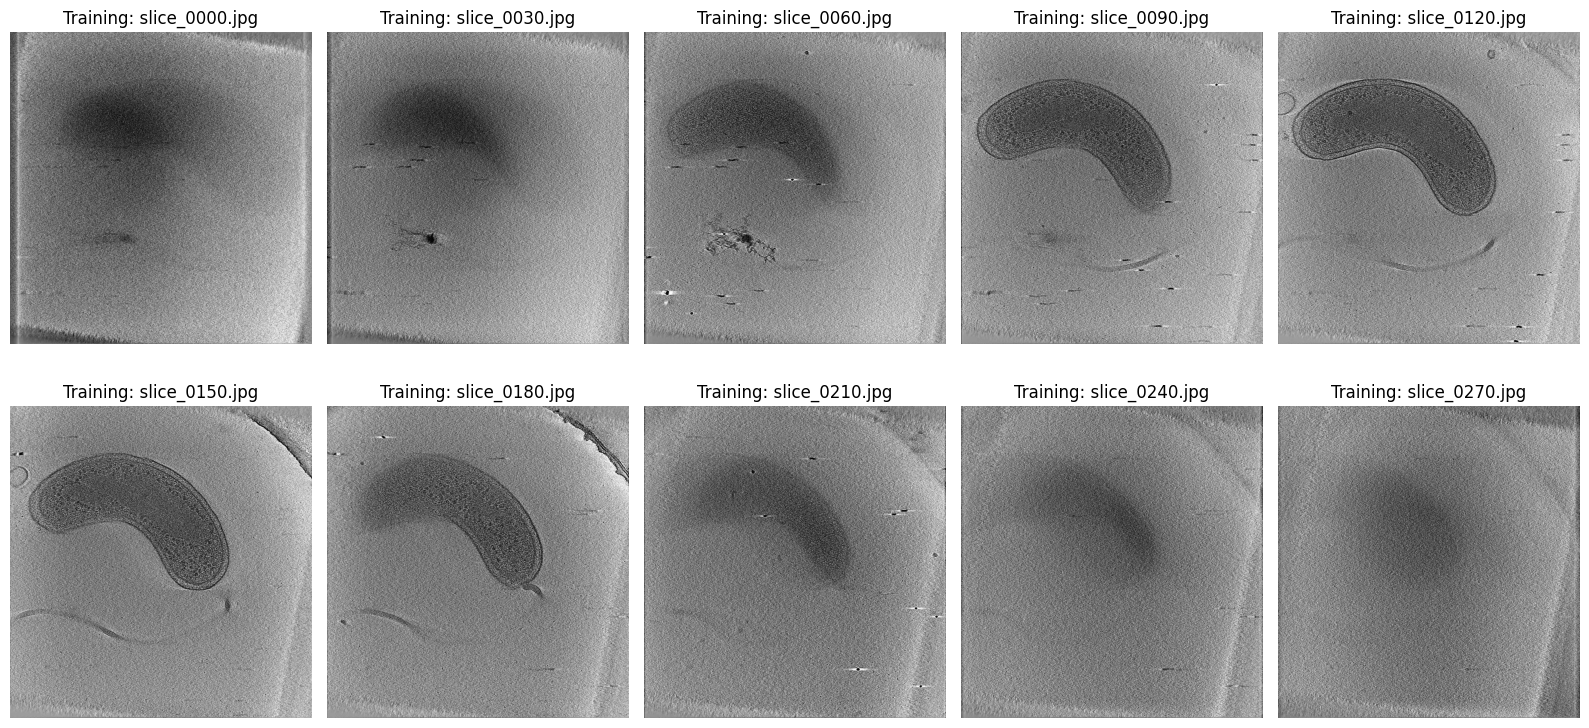

In [10]:
plt.figure(figsize=(16, 8))
rows = 2
cols = (len(training_images) + 1) // 2  # Ceiling division for an odd number of images

for i, img in enumerate(training_images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f'Training: {training_filenames[i]}')
    plt.axis('off')
        
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PATH, 'training_images.png'))
plt.show()

In [11]:
def train_n2v_model_multi(train_images):
    """Train a Noise2Void model on multiple images"""
    datagen = N2V_DataGenerator()
    
    # Process each training image
    all_patches = []
    
    for img in train_images:
        # Prepare the image for N2V - add channel dimension
        img_for_patches = img[np.newaxis, ..., np.newaxis]
        
        # Generate patches for this image
        patches = datagen.generate_patches_from_list([img_for_patches], shape=(64, 64))
        all_patches.append(patches)
    
    # Combine all patches
    X = np.concatenate(all_patches, axis=0)
    print(f"Generated a total of {X.shape[0]} training patches of shape {X.shape[1:]}")
    
    # Split into training and validation (80/20)
    np.random.shuffle(X)
    n_train = int(0.8 * X.shape[0])
    X_train, X_val = X[:n_train], X[n_train:]
    print(f"Training on {n_train} patches, validating on {X.shape[0] - n_train} patches")
    
    # Configure N2V
    config = N2VConfig(
        X_train,
        unet_kern_size=3,
        train_steps_per_epoch=max(int(X_train.shape[0]/128), 10), 
        train_epochs=100,
        train_loss='mse',
        batch_norm=True,
        train_batch_size=128,
        n2v_perc_pix=0.198,
        n2v_patch_shape=(64, 64),
        n2v_manipulator='uniform_withCP',
        n2v_neighborhood_radius=5,
        # N2V2 improvements
        blurpool=True,
        skip_skipone=True,
        unet_residual=True,
    )
    
    # Create and train the model
    model_name = 'n2v_cryoET_8slices'
    model = N2V(config, model_name, basedir=MODEL_PATH)
    
    print("Starting model training...")
    history = model.train(X_train, X_val)
    
    # Plot training history
    plt.figure(figsize=(10, 4))
    plot_history(history, ['loss', 'val_loss'])
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_PATH, 'training_history.png'))
    plt.show()
    
    return model

# Train the model using 8 images
print(f"Training on {len(training_images)} slices with 100 epochs...")
model = train_n2v_model_multi(training_images)

Training on 10 slices with 100 epochs...
Generated patches: (1568, 64, 64, 1)
Generated patches: (1568, 64, 64, 1)
Generated patches: (1568, 64, 64, 1)
Generated patches: (1568, 64, 64, 1)
Generated patches: (1568, 64, 64, 1)
Generated patches: (1568, 64, 64, 1)
Generated patches: (1568, 64, 64, 1)
Generated patches: (1568, 64, 64, 1)
Generated patches: (1568, 64, 64, 1)
Generated patches: (1568, 64, 64, 1)
Generated a total of 15680 training patches of shape (64, 64, 1)
Training on 12544 patches, validating on 3136 patches
Starting model training...
8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 3136/3136 [00:00<00:00, 3456.95it/s]


Epoch 1/100
98/98 [==============================] - 361s 4s/step - loss: 1.5465 - n2v_mse: 1.5465 - n2v_abs: 0.9861 - val_loss: 1.5298 - val_n2v_mse: 1.5298 - val_n2v_abs: 0.9807 - lr: 4.0000e-04
Epoch 2/100
98/98 [==============================] - 350s 4s/step - loss: 1.4294 - n2v_mse: 1.4294 - n2v_abs: 0.9498 - val_loss: 1.5081 - val_n2v_mse: 1.5081 - val_n2v_abs: 0.9738 - lr: 4.0000e-04
Epoch 3/100
98/98 [==============================] - 351s 4s/step - loss: 1.3866 - n2v_mse: 1.3866 - n2v_abs: 0.9347 - val_loss: 1.4464 - val_n2v_mse: 1.4464 - val_n2v_abs: 0.9547 - lr: 4.0000e-04
Epoch 4/100
42/98 [===========>..................] - ETA: 3:11 - loss: 1.3495 - n2v_mse: 1.3495 - n2v_abs: 0.9253

KeyboardInterrupt: 

In [12]:
def process_and_compare(model, images, indices, filenames):
    """Process the selected slices and display before/after comparison"""
    results = []
    original_imgs = []
    denoised_imgs = []
    
    for idx in indices:
        # Get the original image
        original = images[idx]
        original_imgs.append(original)
        
        # Add dimensions for prediction: YXC
        img_for_pred = original[..., np.newaxis]
        
        # Predict (denoise)
        denoised = model.predict(img_for_pred, axes='YXC')
        
        # Remove the channel dimension for display
        denoised = denoised[..., 0]
        denoised_imgs.append(denoised)
        
        # Calculate noise metrics
        noise_before = np.std(original)
        noise_after = np.std(denoised)
        results.append({
            'filename': filenames[idx],
            'noise_before': noise_before,
            'noise_after': noise_after,
            'reduction_percent': (1 - noise_after/noise_before) * 100
        })
    
    # Display comparison
    fig, axes = plt.subplots(2, len(indices), figsize=(20, 8))
    
    for i in range(len(original_imgs)):
        # Original image
        axes[0, i].imshow(original_imgs[i], cmap='gray')
        axes[0, i].set_title(f'Original: {filenames[indices[i]]}')
        axes[0, i].axis('off')
        
        # Denoised image
        axes[1, i].imshow(denoised_imgs[i], cmap='gray')
        axes[1, i].set_title(f'Denoised: {results[i]["reduction_percent"]:.1f}% reduction')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_PATH, 'denoising_comparison.png'))
    plt.show()
    
    # Save individual images
    for i, idx in enumerate(indices):
        Image.fromarray(original_imgs[i].astype(np.uint8)).save(
            os.path.join(OUTPUT_PATH, f'original_{filenames[indices[i]]}'))
        Image.fromarray(denoised_imgs[i].astype(np.uint8)).save(
            os.path.join(OUTPUT_PATH, f'denoised_{filenames[indices[i]]}'))
    
    return results, original_imgs, denoised_imgs

print("Denoising sample slices...")
denoising_results, original_crops, denoised_crops = process_and_compare(model, images, sample_indices, filenames)

Denoising sample slices...


NameError: name 'model' is not defined

In [ ]:
for result in denoising_results:
    print(f"Slice: {result['filename']}")
    print(f"  Noise before: {result['noise_before']:.2f}")
    print(f"  Noise after:  {result['noise_after']:.2f}")
    print(f"  Reduction:    {result['reduction_percent']:.2f}%")
    print("")

In [ ]:
def show_detailed_crops(original_imgs, denoised_imgs, indices, filenames):
    """Show detailed crops of the central region for better comparison"""
    fig, axes = plt.subplots(2, len(indices), figsize=(20, 8))
    
    for i in range(len(original_imgs)):
        # Create a central crop
        h, w = original_imgs[i].shape
        crop_y, crop_x = h//2 - 100, w//2 - 100
        crop_h, crop_w = 200, 200
        
        crop_original = original_imgs[i][crop_y:crop_y+crop_h, crop_x:crop_x+crop_w]
        crop_denoised = denoised_imgs[i][crop_y:crop_y+crop_h, crop_x:crop_x+crop_w]
        
        # Original crop
        axes[0, i].imshow(crop_original, cmap='gray')
        axes[0, i].set_title(f'Original: {filenames[indices[i]]} (crop)')
        axes[0, i].axis('off')
        
        # Denoised crop
        axes[1, i].imshow(crop_denoised, cmap='gray')
        axes[1, i].set_title('Denoised (crop)')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_PATH, 'detailed_crop_comparison.png'))
    plt.show()

show_detailed_crops(original_crops, denoised_crops, sample_indices, filenames)

In [ ]:
def process_all_slices():
    """Process and save denoised versions of all slices"""

    
    print(f"Processing all {len(images)} test slices...")
    output_dir = os.path.join(OUTPUT_PATH, 'all_denoised')
    os.makedirs(output_dir, exist_ok=True)
    
    for i, (img, fname) in enumerate(tqdm(zip(images, filenames), total=len(images))):
        # Add channel dimension for prediction
        img_for_pred = img[..., np.newaxis]
        
        # Denoise the image
        denoised = model.predict(img_for_pred, axes='YXC')[..., 0]
        
        # Save the denoised image
        output_path = os.path.join(output_dir, f'denoised_{fname}')
        Image.fromarray(denoised.astype(np.uint8)).save(output_path)
    
    print(f"All slices processed and saved to {output_dir}")

# Uncomment to enable processing all slices
# process_all_slices()

print("Noise2Void multi-slice training completed successfully!")